In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
np.linspace(0, 2, 21)[1:]

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [82]:
class CosineScheduler:
    def __init__(self, t_0: float, t_f: float, s: float = 0.0):
        self.t_0 = t_0
        self.t_f = t_f
        self.s = s

    def lambda_t0(self, t):
        return 1 - np.cos(0.5 * np.pi * ((t / self.t_f) + self.s) / (1 + self.s)) ** 2

    def lambda_t(self, t1, t0):
        return 1 - np.exp(
            -np.abs(
                np.log(
                    np.cos(0.5 * np.pi * ((t1 / self.t_f) + self.s) / (1 + self.s))
                    ** 2
                )
                - np.log(
                    np.cos(0.5 * np.pi * ((t0 / self.t_f) + self.s) / (1 + self.s))
                    ** 2
                )
            )
        )

def cos_sq_fn_step_scheme(
    start, end, dt, s=0.008, dtype=np.float32, **_):
  """Exponential decay step scheme from Nichol and Dhariwal 2021.

  Args:
    start: start time defaults to 0
    end: end time defaults to 1
    dt: number of steps to divide grid into
    s: shift to ensure non 0
    dtype: for tpu support
    **_: placeholder to handle different scheme args

  Returns:
    time grid
  """
  n_steps = int((end - start) / dt)

  pre_phase = np.linspace(start, end, n_steps, dtype=dtype) / end
  phase = ((pre_phase + s) / (1 + s)) * np.pi * 0.5
  # Note this multiples small numbers however implemented it more stably
  # (removed sqrt from solver only sqrd here) and it made no difference to
  # results
  dts = np.cos(phase)**4

  # dts /= dts.sum()
  # dts *= end  # We normalise s.t. \sum_k \beta_k = T (where beta_k = b_m*cos^4)

  dts_out = np.concatenate((np.array([start]), np.cumsum(dts)))
  return dts_out

def nichol_step_scheme(
    start, end, dt, s=0.008, dtype=np.float32, **_):
  """Exponential decay step scheme from Nichol and Dhariwal 2021.

  Args:
    start: start time defaults to 0
    end: end time defaults to 1
    dt: number of steps to divide grid into
    s: shift to ensure non 0
    dtype: for tpu support
    **_: placeholder to handle different scheme args

  Returns:
    time grid
  """
  n_steps = int((end - start) / dt)

  pre_phase = np.linspace(start, end, n_steps, dtype=dtype) / end
  phase = ((pre_phase + s) / (1 + s)) * np.pi * 0.5
  # Note this multiples small numbers however implemented it more stably
  # (removed sqrt from solver only sqrd here) and it made no difference to
  # results
  dts = np.cos(phase)**2

  # dts /= dts.sum()
  # dts *= end  # We normalise s.t. \sum_k \beta_k = T (where beta_k = b_m*cos^4)

  dts_out = np.concatenate((np.array([start]), np.cumsum(dts)))
  return dts_out

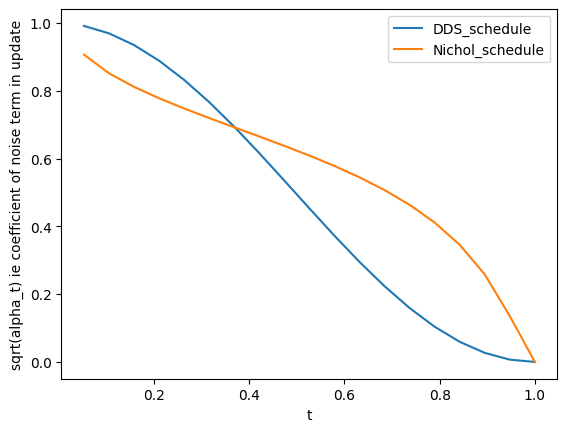

In [83]:
t0 = 0.0
t1 = 1.0
# dt = 0.05
# K = int(t1/dt)
K = 20
dt = t1/K
alpha = 1.0
s = 0.008

ts = cos_sq_fn_step_scheme(t0, t1, dt)[1:]
beta_k = np.clip(alpha * np.sqrt(ts[1:] - ts[:-1]), 0, 1)

ts = nichol_step_scheme(t0, t1, dt)[1:]
beta_k_nichol = np.clip(alpha * np.sqrt(ts[1:] - ts[:-1]), 0, 1)

cosine_schedule =  CosineScheduler(t0, t1, s)
ts = np.linspace(t0, t1, K)
lambda_k = cosine_schedule.lambda_t(ts[:-1], ts[1:])

plt.plot(ts[1:], beta_k, label='DDS_schedule')
plt.plot(ts[1:], 1 - np.sqrt(lambda_k), label='Nichol_schedule')
# plt.plot(ts[1:], np.sqrt(alpha)*np.cos((np.pi * (ts[1:] + s))/(2 *(1+s)))**2, label='DDS_schedule (unnorm)')
# plt.plot(ts[1:], beta_k_nichol, label='Nichol_schedule_dds_codebase')
plt.legend()
plt.xlabel('t')
plt.ylabel('sqrt(alpha_t) ie coefficient of noise term in update')
plt.show()